
Running DBSCAN with eps=0.012, min_samples=15
{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.cr

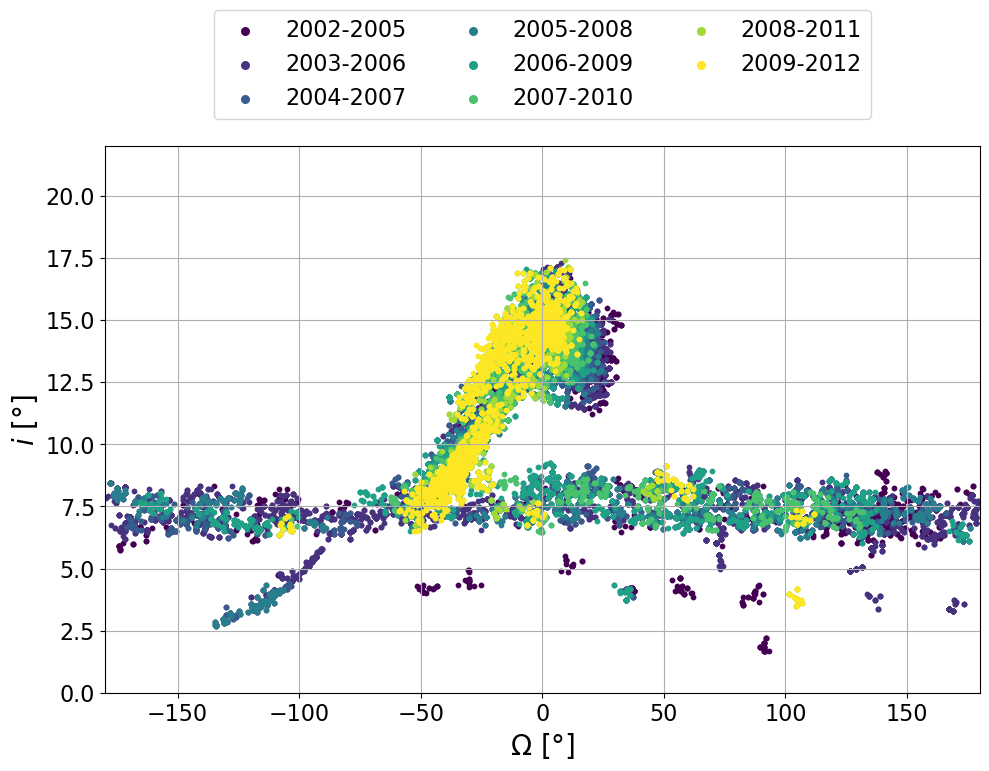

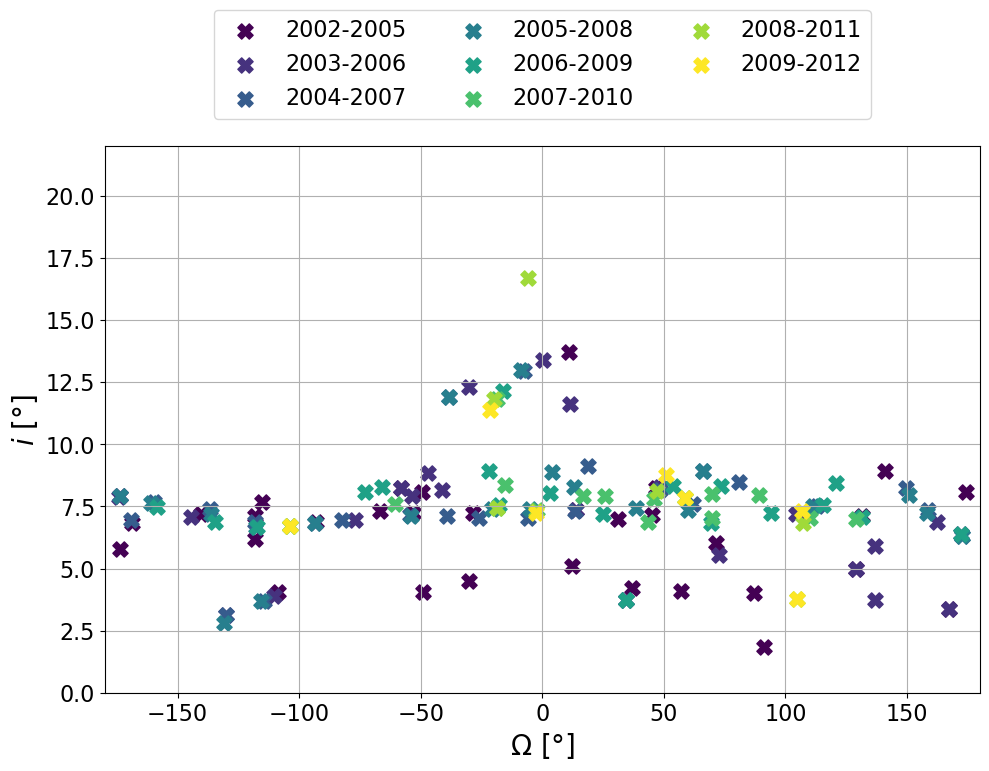


Running DBSCAN with eps=0.012, min_samples=17
{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.cr

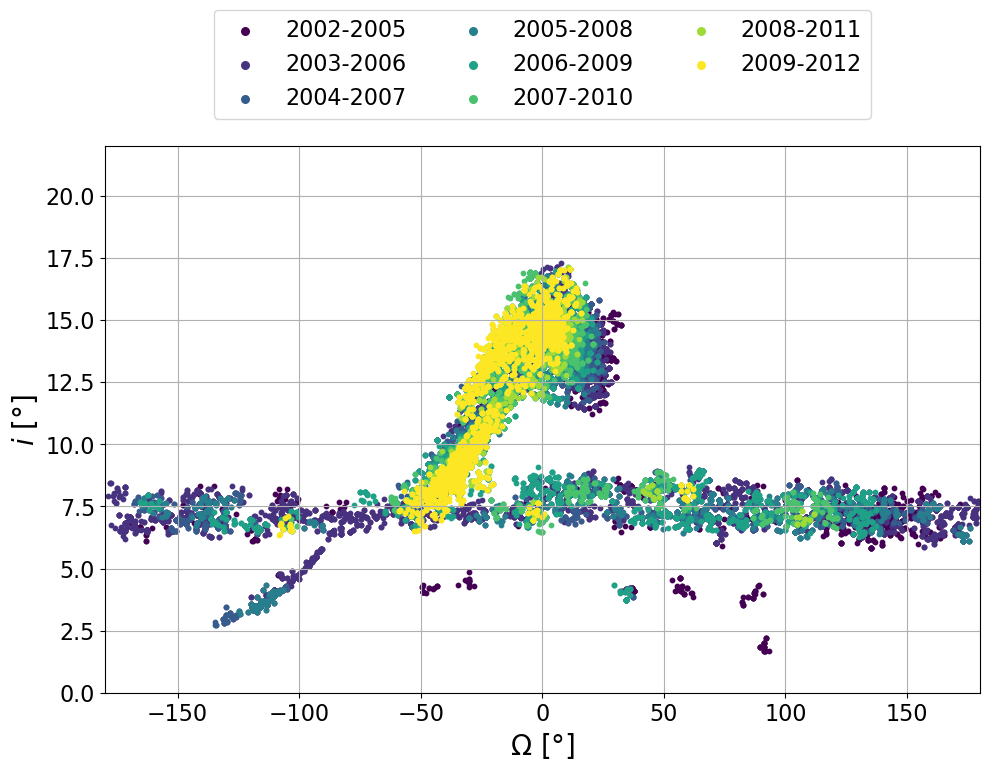

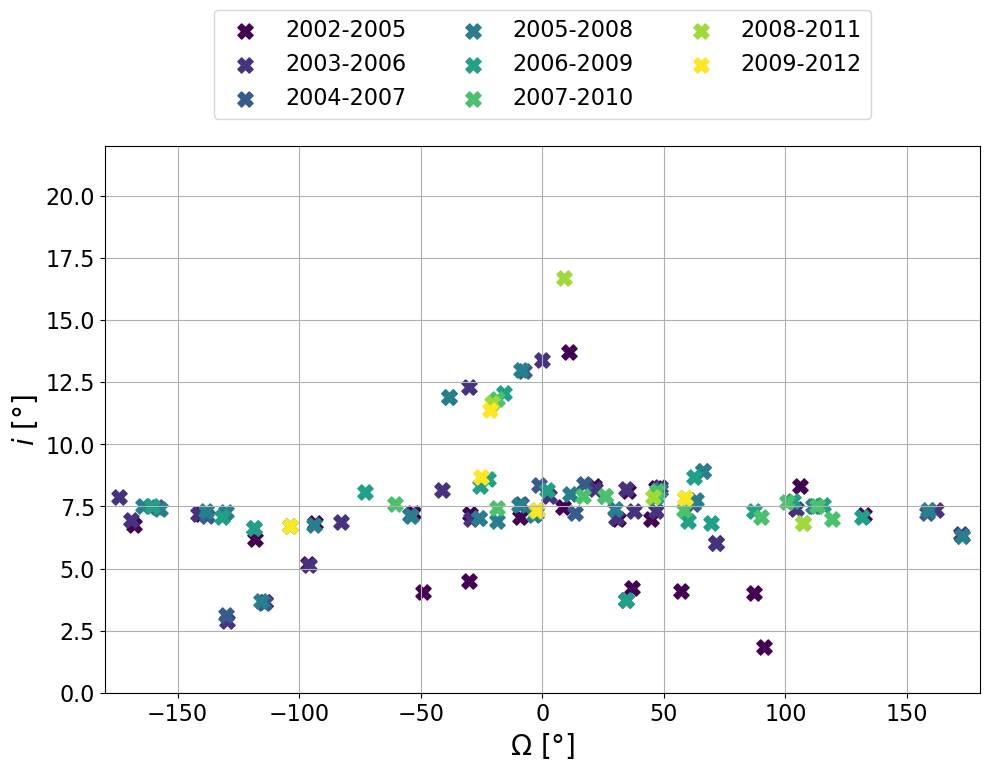


Running DBSCAN with eps=0.012, min_samples=20
{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.cr

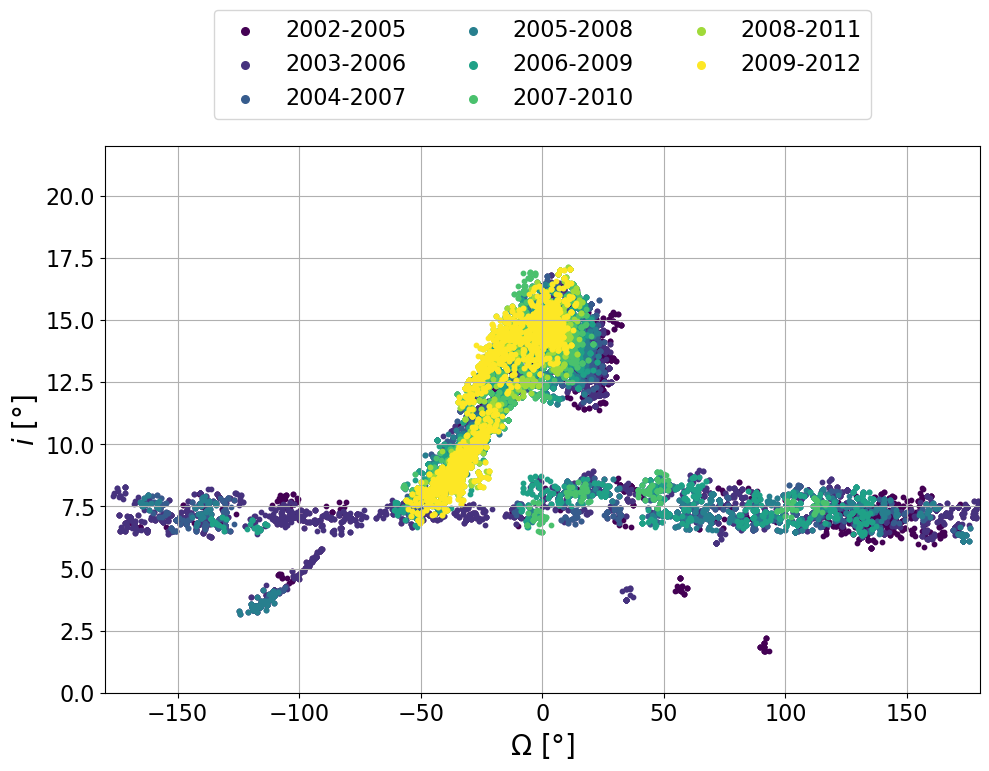

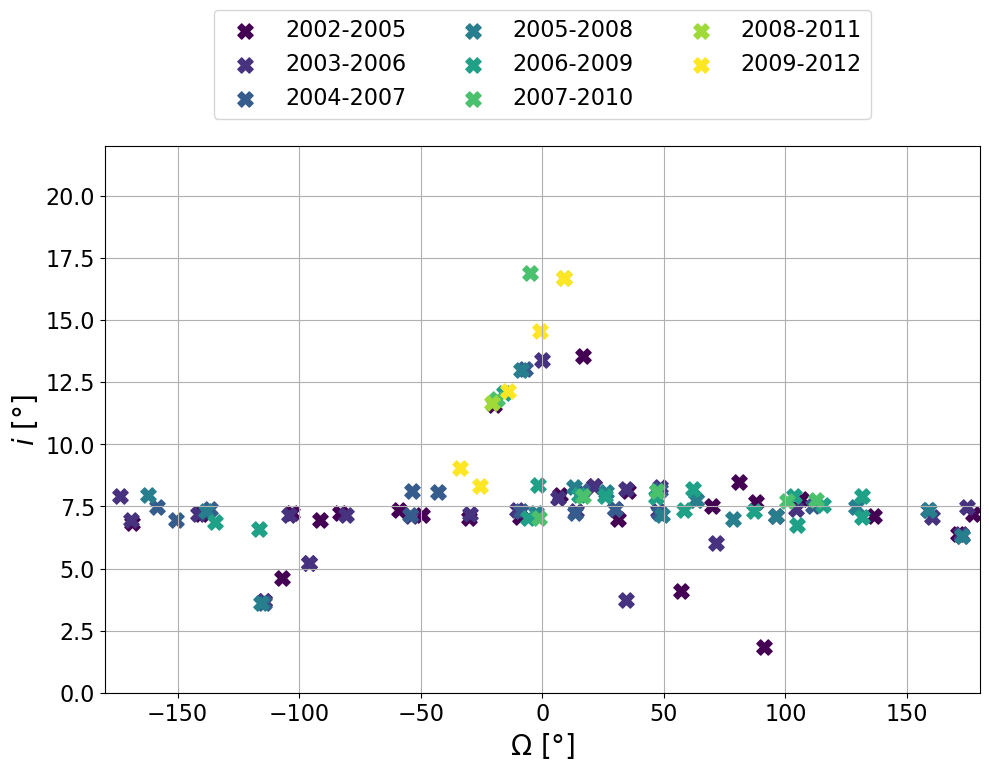


Running DBSCAN with eps=0.01, min_samples=15
{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs

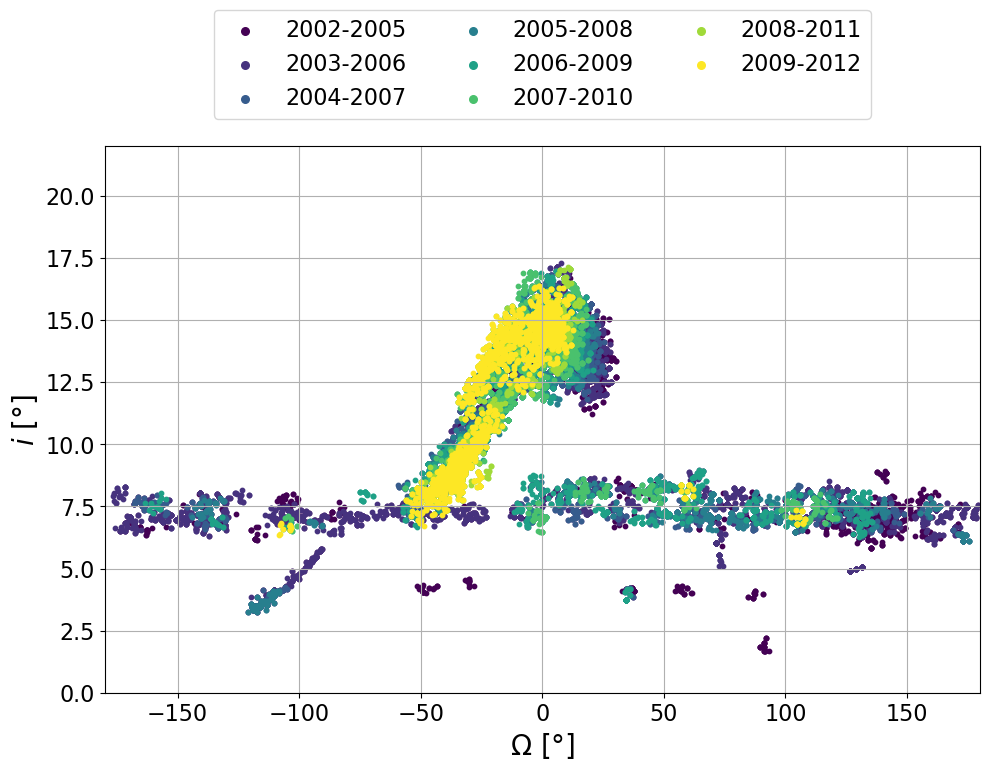

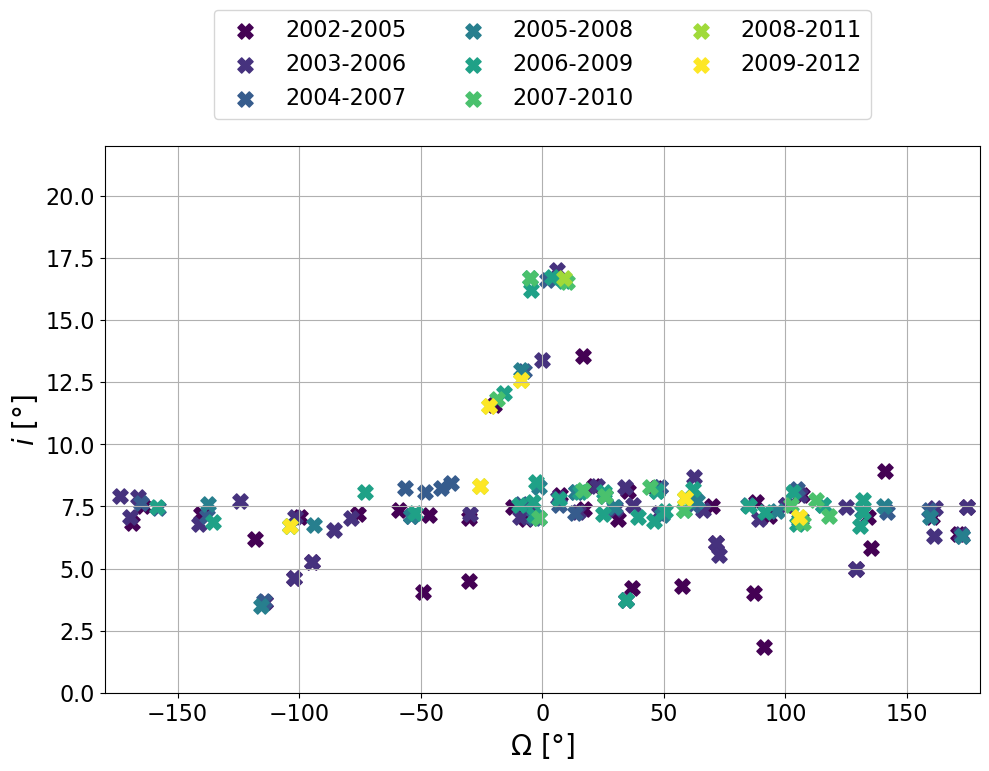


Running DBSCAN with eps=0.01, min_samples=17
{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs

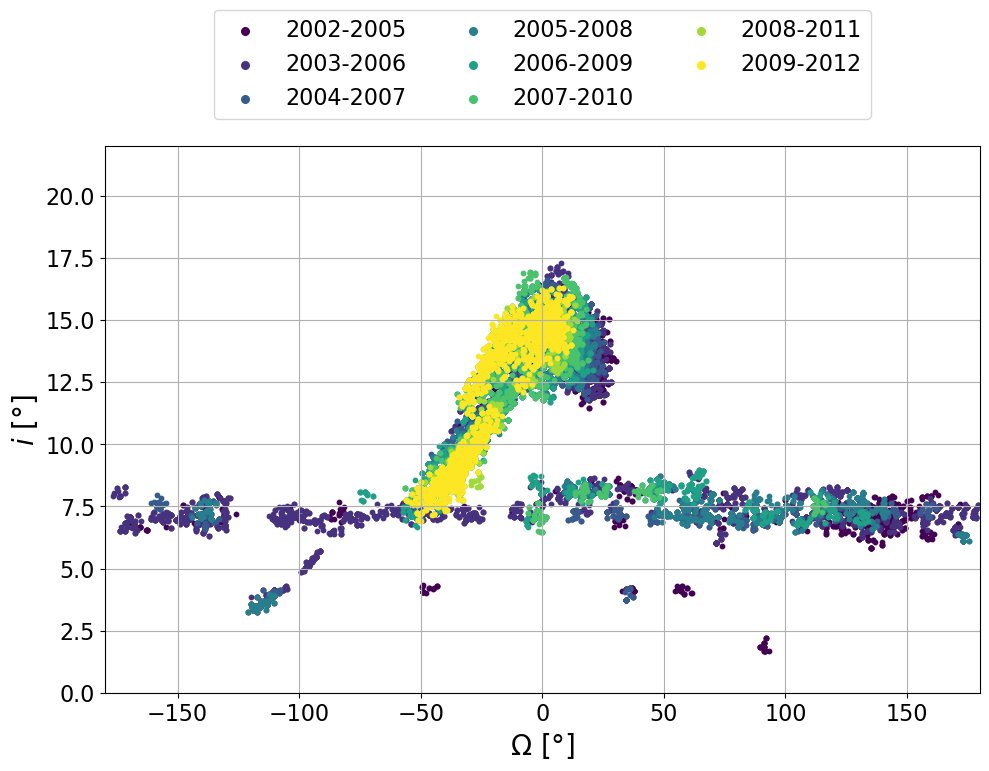

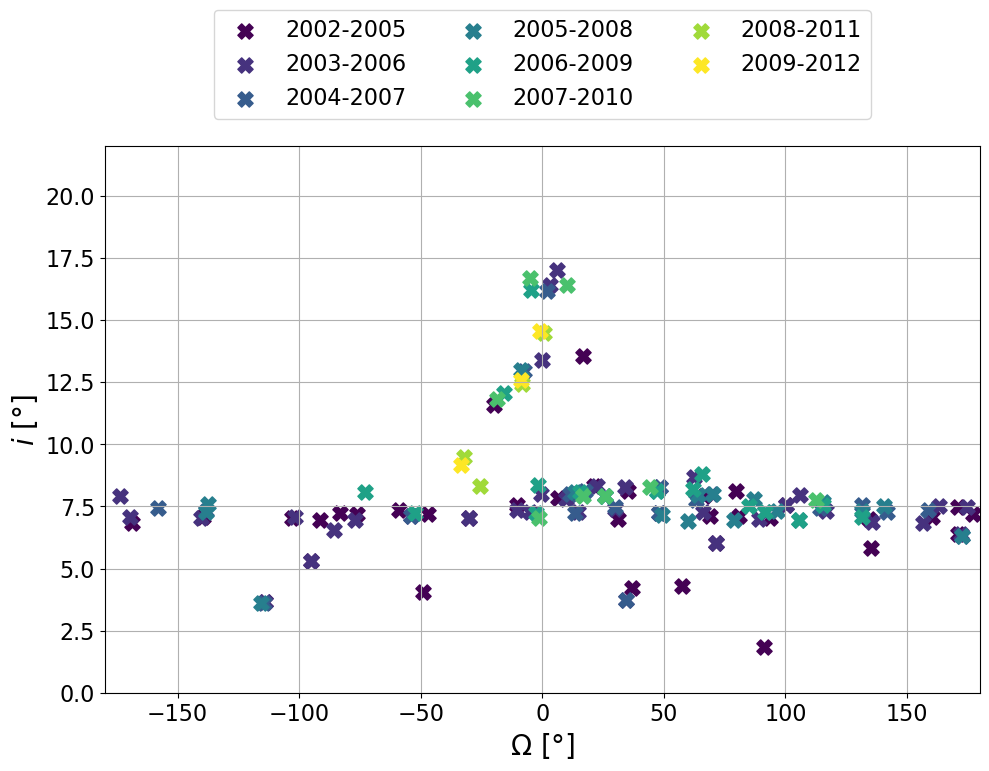


Running DBSCAN with eps=0.01, min_samples=20
{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs

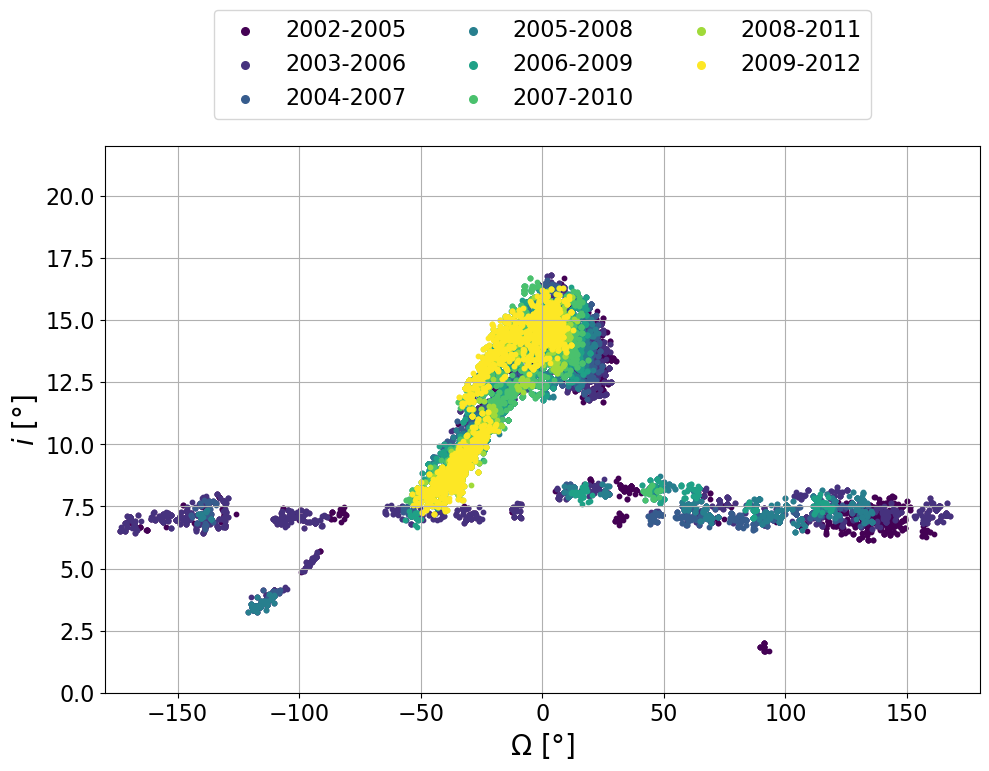

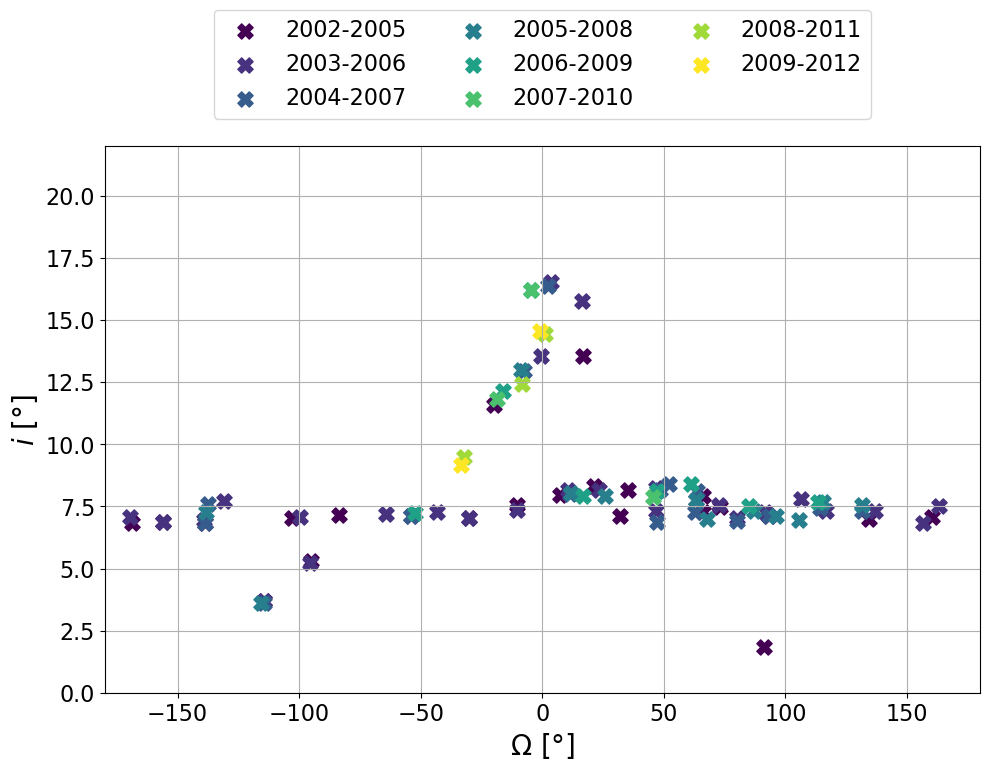


Running DBSCAN with eps=0.015, min_samples=15
{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.cr

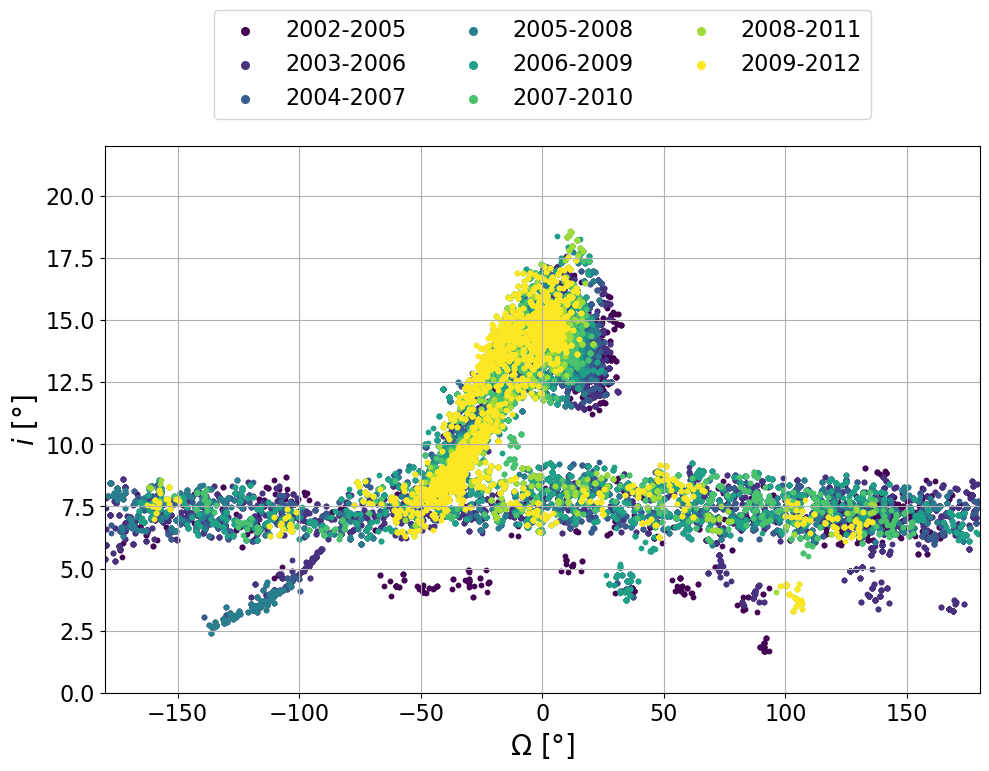

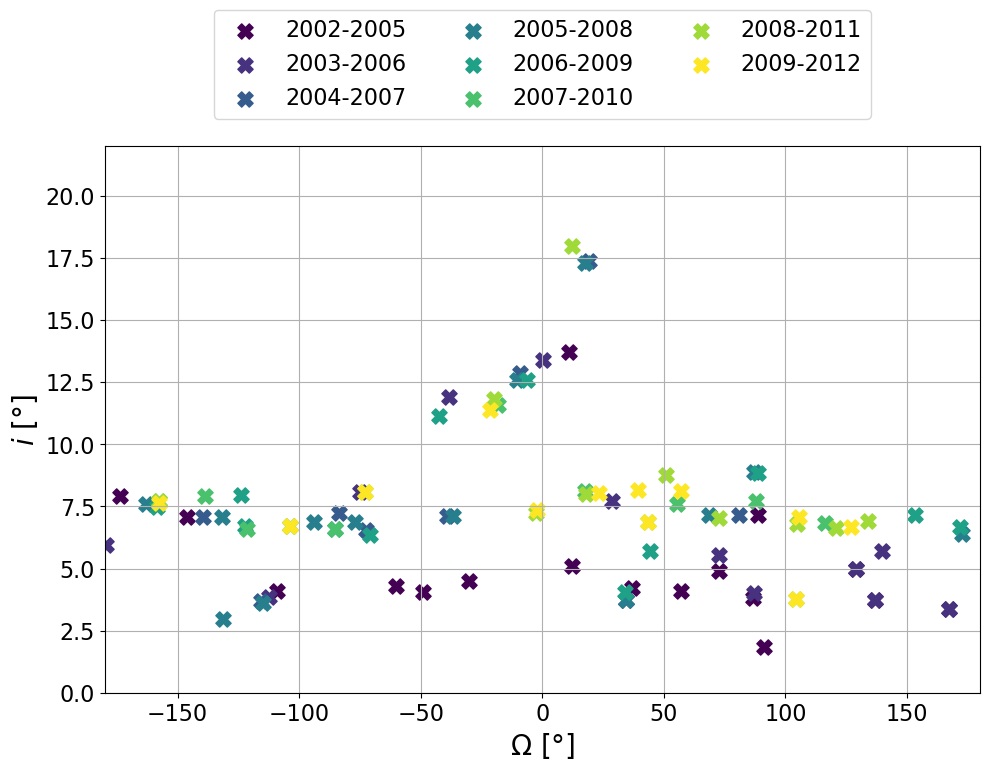


Running DBSCAN with eps=0.015, min_samples=17
{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.cr

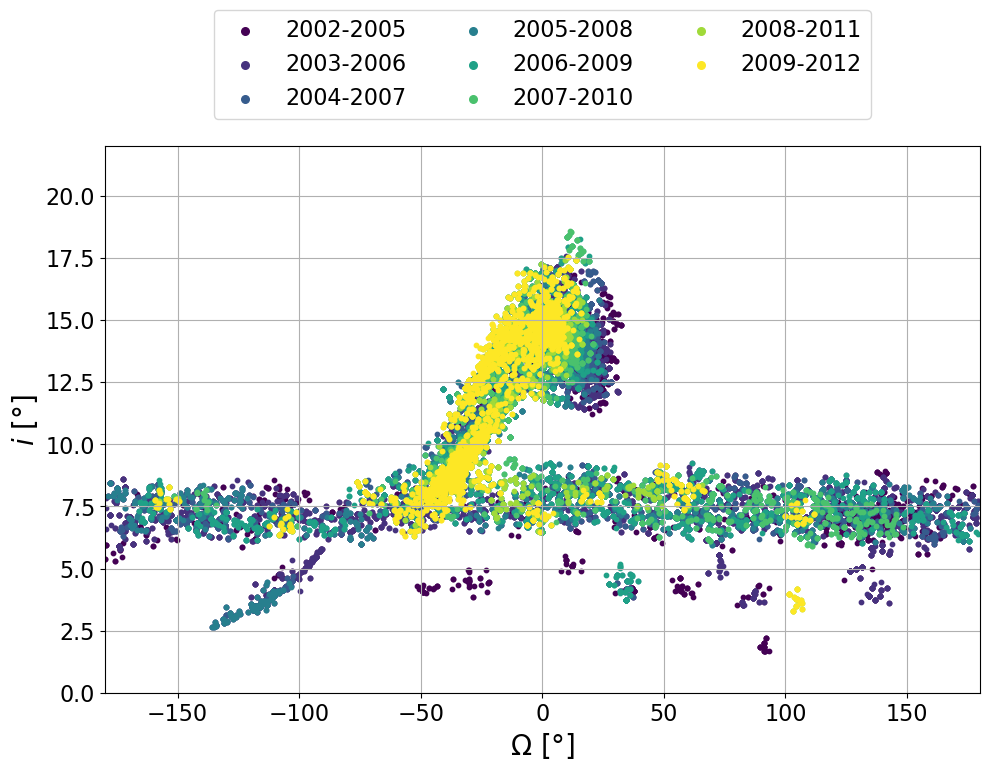

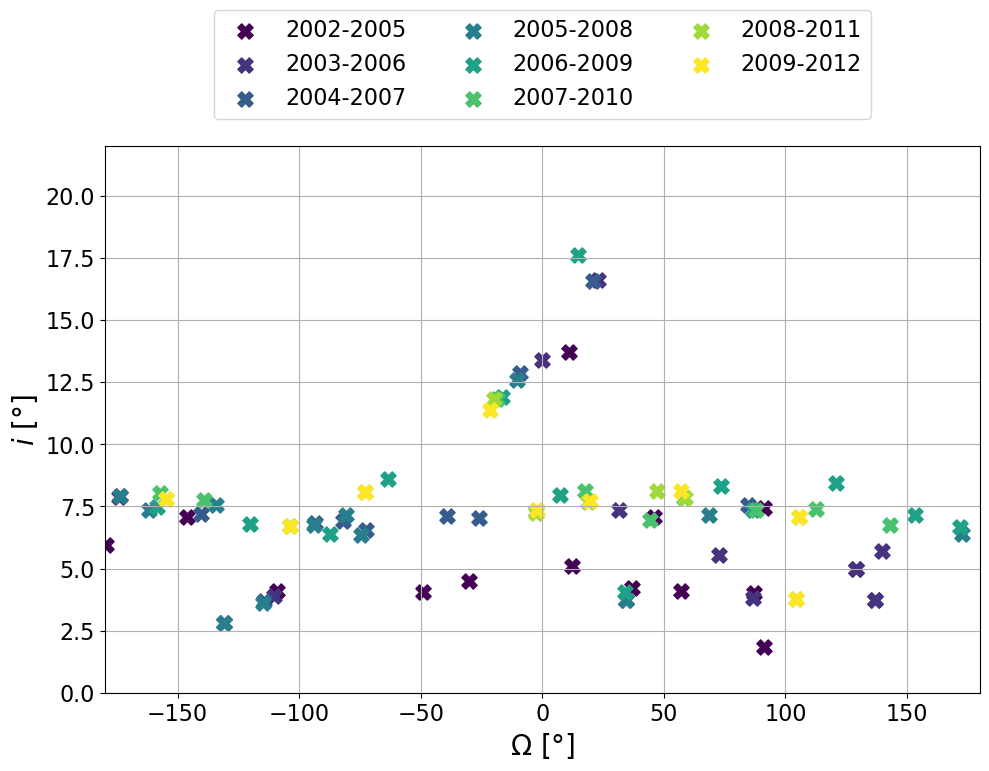


Running DBSCAN with eps=0.015, min_samples=20
{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.cr

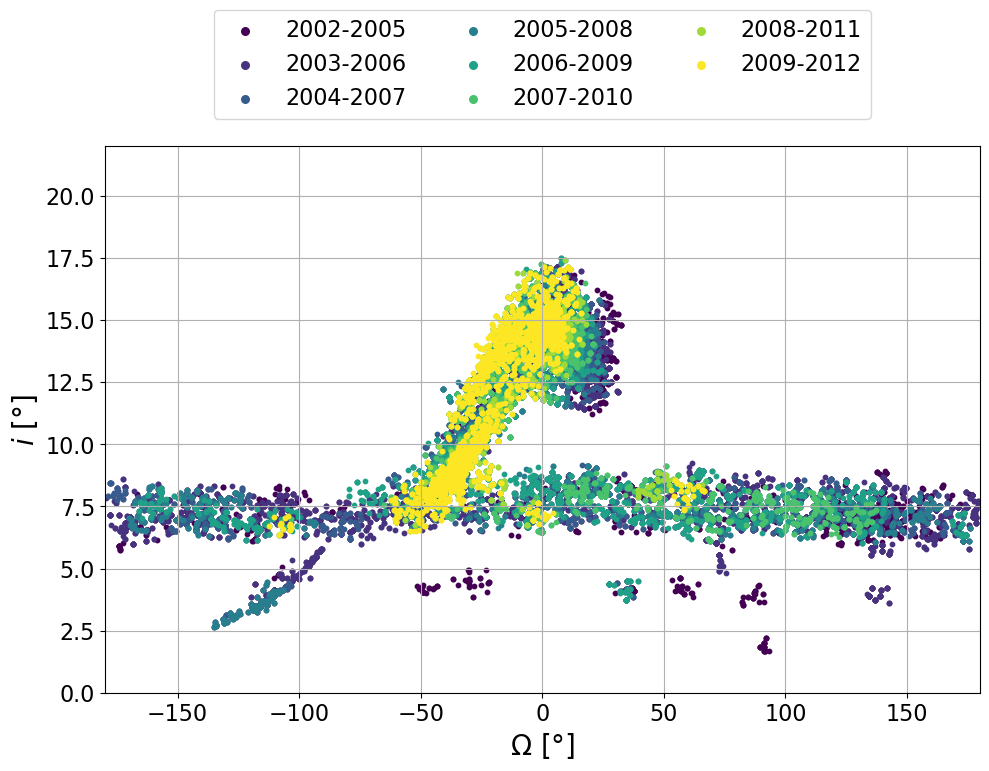

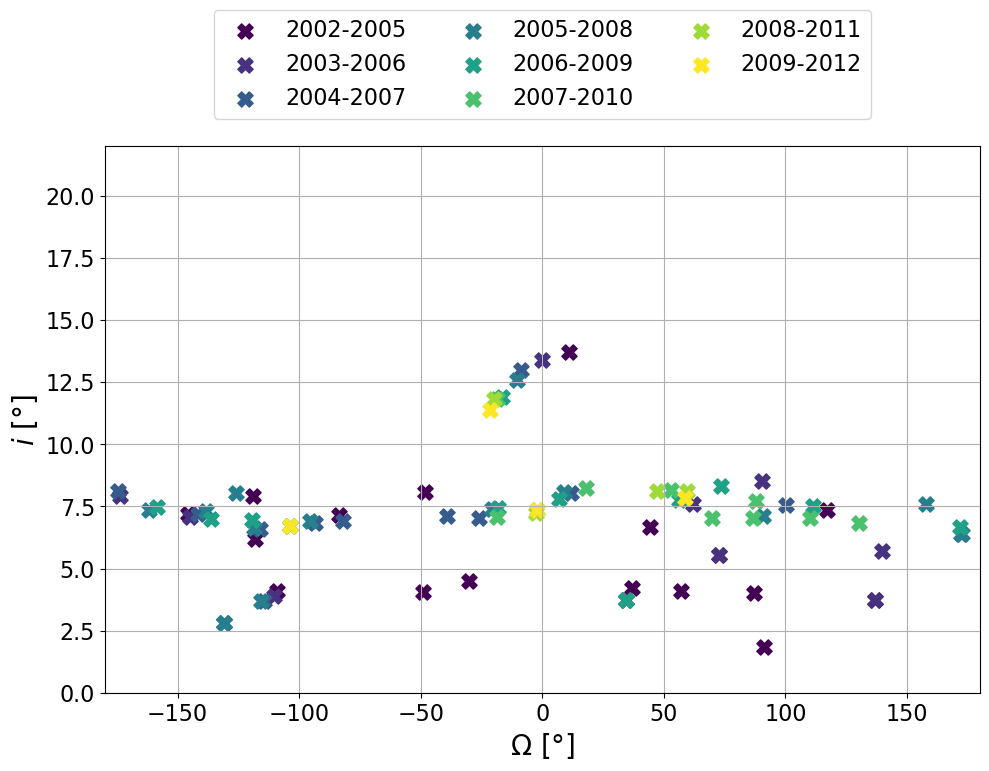

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from DBSCAN import dbscan_clustering
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize

# --- Parameters ---
eps_vals = [0.012, 0.01, 0.015]
min_samples_vals = [15, 17, 20]
year_ranges = cluster_data.generate_running_year_ranges(2002, 2012, 4)

# --- Medoid function ---
def compute_medoid(points):
    if len(points) == 0:
        return None
    distances = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=2)
    avg_distances = distances.mean(axis=1)
    return points[np.argmin(avg_distances)]

# --- Loop over parameters ---
for eps in eps_vals: 
    for min_samples in min_samples_vals:
        print(f"\nRunning DBSCAN with eps={eps}, min_samples={min_samples}")

        # --- Run clustering ---
        results = {}
        for data, year_range in cluster_data.bin_data_for_clustering(year_ranges, print_res=False):
            arr = np.array([data.inc, data.raan]).T
            normed, dmin, dmax = normalize_data(arr)

            result, _, n_clusters, _, _ = run_clustering(
                dbscan_clustering, "DBSCAN", normed, dmin, dmax, plot=False,
                eps=eps, min_samples=min_samples
            )

            unnormed, _ = unnormalize(result.data, None, dmin, dmax)
            results[year_range] = (unnormed, result.labels)

        # --- Plot settings ---
        label_fontsize = 20
        tick_fontsize = 16
        legend_fontsize = 16
        colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

        # --- 1) Clusters plot ---
        plt.figure(figsize=(10, 8))
        for (year_range, (data, labels)), color in zip(results.items(), colors):
            mask = labels != -1  # exclude noise
            plt.scatter(data[mask, 1], data[mask, 0], s=10, color=color, label=year_range)

        plt.xlabel("$\\Omega$ [°]", fontsize=label_fontsize)
        plt.ylabel("$i$ [°]", fontsize=label_fontsize)
        plt.xlim(-180, 180)
        plt.ylim(0, 22)
        plt.xticks(fontsize=tick_fontsize)
        plt.yticks(fontsize=tick_fontsize)
        legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=3, fontsize=legend_fontsize)
        for lh in legend.legend_handles:
            lh.set_sizes([30])
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- 2) Medoids plot ---
        plt.figure(figsize=(10, 8))
        for (year_range, (data, labels)), color in zip(results.items(), colors):
            medoids = []
            for k in set(labels):
                if k == -1:  # skip noise
                    continue
                cluster_points = data[labels == k]
                medoid = compute_medoid(cluster_points)
                if medoid is not None:
                    medoids.append(medoid)
            medoids = np.array(medoids)
            if len(medoids) > 0:
                plt.scatter(medoids[:, 1], medoids[:, 0], s=120, marker="X", color=color, label=year_range)

        plt.xlabel("$\\Omega$ [°]", fontsize=label_fontsize)
        plt.ylabel("$i$ [°]", fontsize=label_fontsize)
        plt.xlim(-180, 180)
        plt.ylim(0, 22)
        plt.xticks(fontsize=tick_fontsize)
        plt.yticks(fontsize=tick_fontsize)
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.27), ncol=3, fontsize=legend_fontsize)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
